# Atividade prática 3
### Retoque de imagens digitais

Sabe quando a gente tira do baú um álbum de família, mas quando viramos uma página, eis que alguns pedaços de uma fotografia ficam grudados nele?
Há um tempo atrás, muita gente experimentou esta situação.
Nos dias de hoje, isto pode ser transposto para o contexto das fotos digitais, por exemplo, quando desejamos recuperar uma foto antiga deteriorada que foi digitalizada ou remover algum objeto indesejado presente na cena.
Este tipo de problema é o conhecido como **retoque digital**.
Nesta atividade, você aprenderá como implementar um algoritmo simples de retoque digital que se resume em resolver um sistema de equações algébricas lineares.

## Imagens digitais

Uma *imagem digital* pode ser vista como uma matriz $\mathbf{P} = \left[ p_{ij} \right]$, $n_x\times n_y$, onde cada elemento $p_{ij}$ é denominado *pixel*.
Existem diversas formas de se representar a cor de um pixel.
No sistema conhecido como RGB (do inglês, *Red*, *Green*, *Blue*), a cor de um pixel é representada usando três canais: <font color="red">vermelho</font>, <font color="green">verde</font> e <font color="blue">azul</font>.
Supondo cada canal representado com 8 bits, teremos $2^8 = 256$ valores distintos por canal.
A combinação dos três canais possibilita a criação de 256 x 256 x 256 cores, o que é algo em torno de 16 milhões de cores.

Matematicamente, a cor de um pixel $p_{i,j}$ é representada por uma vetor $\left( r, g, b\right)$, onde $0 \le r,g,b \le 255$.
Quanto maior o valor de um canal, maior será a intensidade dele na cor final obtida.
Algumas exemplos de combinações de canais são:

* $(255,0,0)$: <font color="#ff0000">vermelho</font>
* $(0,255,0)$: <font color="#00ff00">verde</font>
* $(0,0,255)$: <font color="#0000ff">azul</font>
* $(255,255,0)$: <font color="#ffff00">amarelo</font>
* $(0,255,255)$: <font color="#00ffff">ciano</font>
* $(255,0,255)$ <font color="#ff00ff">magenta</font>
* $(0,0,0)$: <font color="#000000">preto</font>
* $(127,127,127)$: <font color="#777777">cinza médio</font>
* $(255,255,255)$: <font color="#ffffff">branco</font> (não dá para ver, não é? :))

Em Python, fica fácil manipular imagens usando a biblioteca `imageio`:

In [1]:
import numpy as np
import imageio

Ao carregar uma imagem a partir de um endereço

In [32]:
imagem = imageio.imread('https://drive.google.com/uc?export=view&id=1q5FvP0NRk5Uy6LGLG4-ooj9jVi1umyYr')

o resultado é um arranjo NumPy.
Você pode também abrir um arquivo em seu computador passando o caminho absoluto ou relativo até a imagem desejada para a função `imageio.imread`.

Depois de carregar a imagem, podemos exibir suas dimensões (o que chamamos de *resolução espacial*) e a quantidade de canais presentes:

In [3]:
nx,ny,nc = imagem.shape
nx,ny,nc

(256, 256, 3)

Os números acima significam que a imagem possui 256 pixels de altura, 256 pixels de largura e 3 canais de cores.
Algumas imagens apresentam também um canal de transparência, conhecido como canal *alfa*.
No entanto, considerando o que precisamos fazer nesta tarefa, este canal pode ser ignorado.

Como a imagem agora é um `numpy.array`, podemos acessar um pixel $p_{i,j}$ usando indexação. Por exemplo, o conteúdo do pixel $p_{2,3}$ é

In [4]:
R = imagem[2,3,0]
G = imagem[2,3,1]
B = imagem[2,3,2]
R,G,B

(162, 91, 56)

O resultado acima contém os valores RGB do pixel $p_{2,3}$, além do tipo utilizado para armazená-los, que neste caso é um `uint8` (um inteiro não negativo ocupando 8 bits).

Para exibir a `imagem`, podemos usar a `matplotlib`:

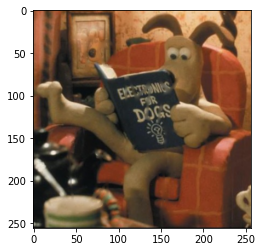

In [29]:
import matplotlib.pyplot as plt

plt.imshow(imagem) # cria um gráfico cujo fundo é a imagem
plt.show() # exibe o gráfico criado'

## Algoritmo de retoque digital

O objetivo de um algoritmo de retoque é preencher porções de pixels indesejados de uma foto baseando-se nas cores de pixels vizinhos que serão preservados.
Um bom algoritmo deve produzir uma imagem nova com emendas imperceptíveis entre as regiões que foram mantidas intactas e aquelas recém preenchidas por ele.
A imagem abaixo contém um exemplo de aplicação de um algoritmo de retoque.
Do lado esquerdo, a imagem original, com riscos em vermelho, e o resultado final do lado direito, com os riscos removidos.

<img style="height:256px" src="https://www.pyimagesearch.com/wp-content/uploads/2020/05/opencv_inpainting_header.jpg"/>

Um algoritmo simples de retoque funciona do seguinte modo.
Primeiramente, você deve indicar quais pixels na imagem você deseja retocar.
Isto pode ser feito pintando a região indesejada utilizando uma única cor de código conhecido, por exemplo, amarelo ou vermelho, como nas imagens acima.
Por conveniência, assumiremos que nenhum pixel indesejado pertencerá à borda da imagem.

Suponha que $P = \left[p_{i,j}\right]$ é a imagem já com as regiões indesejadas indicadas em <font color="yellow">amarelo</font>.
Se a cor de $p_{i,j}$ for diferente de amarelo, então esse pixel deverá ser preservado e nada será feito com relação a ele.
Caso contrário, sua cor será recalculada como a seguir.

Considere os pixels vizinhos de $p_{i,j}$ localizados imediatamente acima $p_{i-1,j}$, abaixo $p_{i+1,j}$, à esquerda $p_{i,j-1}$ e à direita $p_{i,j+1}$.
A nova cor de $p_{i,j}$ será a média aritmética das cores de seus vizinhos, isto é,

$$
(r_{i,j},g_{i,j},b_{i,j}) = \frac{1}{4} \left[ (r_{i-1,j},g_{i-1,j},b_{i,j}) + (r_{i,j-1},g_{i,j-1},b_{i,j-1}) + (r_{i,j+1},g_{i,j+1},b_{i,j+1}) + (r_{i+1,j},g_{i+1,j},b_{i+1,j}) \right]
$$

Considerando apenas o canal R (vermelho), por simplicidade, podemos escrever esta expressão da seguinte forma:

$$
-r_{i-1,j} - r_{i,j-1} + 4 r_{i,j} - r_{i,j+1} - r_{i+1,j} = 0
$$

Se um dos pixels vizinhos de $p_{i,j}$ precisar ser preservado, sua cor deve ser tratada como constante. Neste caso, esta parcela deverá ser transferida para a direita desta equação.

Supondo um total de $N$ pixels indesejados, a aplicação da equação acima em cada um deles resultará em três sistemas lineares com $N$ equações e $N$ incógnitas, um para cada canal RGB, todos com a mesma matriz de coeficientes.

\begin{align*}
\mathbf{A}\mathbf{x}_r &= \mathbf{b}_r\\
\mathbf{A}\mathbf{x}_g &= \mathbf{b}_g\\
\mathbf{A}\mathbf{x}_b &= \mathbf{b}_b
\end{align*}

Após resolver estes sistemas, basta atualizar as cores dos pixels indesejados com aquelas que foram calculadas e voilà! Sua imagem terá sido retocada!

**Exemplo.** Considere uma imagem $4 \times 4$ como abaixo.

<table width="500" border="1">
        <tr>
            <td bgcolor="green"></td>
            <td bgcolor="blue"></td>
            <td bgcolor="blue"></td>
            <td bgcolor="green"></td>
        </tr>
        <tr>
            <td bgcolor="blue"></td>
            <td bgcolor="green"></td>
            <td bgcolor="yellow"></td>
            <td bgcolor="green"></td>
        </tr>
        <tr>
            <td bgcolor="red"></td>
            <td bgcolor="blue"></td>
            <td bgcolor="yellow"></td>
            <td bgcolor="red"></td>
        </tr>
        <tr>
            <td bgcolor="blue"></td>
            <td bgcolor="green"></td>
            <td bgcolor="green"></td>
            <td bgcolor="red"></td>
        </tr>
</table>

Suponha que os pixels indesejados estão marcados em amarelo.
Portanto, desejamos recalcular as cores dos pixels $p_{1,2}$ e $p_{2,2}$.

Consideremos agora apenas o canal R para compreendermos a forma da matriz $\mathbf{A}$ dos coeficientes do sistema.
Para o primeiro pixel indesejado $p_{1,2}$, temos as equação

$$
-r_{0,2} - r_{1,1} + 4 r_{1,2} - r_{1,3} - r_{2,2} = 0
$$

Já para o pixel $p_{2,2}$, obtemos

$$
-r_{1,2} - r_{2,1} + 4 r_{2,2} - r_{2,3} - r_{3,2} = 0
$$

Como todos os demais pixels devem ser preservados (são constantes), podemos reescrever as equações acima como:

$$
 4 r_{1,2} - r_{2,2} = r_{0,2} + r_{1,1} + r_{1,3}
$$
$$
-r_{1,2} + 4 r_{2,2} = r_{2,1} + r_{2,3} + r_{3,2}
$$

que matricialmente fica:

$$
\begin{bmatrix}
 4 & - 1\\
-1 & 4 
\end{bmatrix}
\begin{bmatrix}
r_{1,2}\\
r_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
r_{0,2} + r_{1,1} + r_{1,3}\\
r_{2,1} + r_{2,3} + r_{3,2}
\end{bmatrix}
$$

Procedendo de modo análogo, montamos os sistemas para os canais G e B:

$$
\begin{bmatrix}
 4 & - 1\\
-1 & 4 
\end{bmatrix}
\begin{bmatrix}
g_{1,2}\\
g_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
g_{0,2} + g_{1,1} + g_{1,3}\\
g_{2,1} + g_{2,3} + g_{3,2}
\end{bmatrix}
$$

$$
\begin{bmatrix}
 4 & - 1\\
-1 & 4 
\end{bmatrix}
\begin{bmatrix}
b_{1,2}\\
b_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
b_{0,2} + b_{1,1} + b_{1,3}\\
b_{2,1} + b_{2,3} + b_{3,2}
\end{bmatrix}
$$

Resolvendo esses sistemas e atualizando a imagem com os novos valores de cores calculados para os pixels indesejados, teremos a imagem retocada.

## Descrição da tarefa

A tarefa de vocês é implementar o algoritmo de retoque descrito acima para remover os riscos amarelos contidos na imagem:

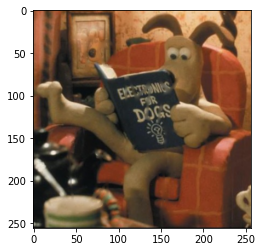

In [28]:
plt.imshow(imagem) # cria um gráfico cujo fundo é a imagem
plt.show() # exibe o gráfico criado'


Por conveniência, sua tarefa foi dividida em 7 etapas:

1. [Numeração das incógnitas](#Numeração-das-incógnitas)
1. [Montagem do sistema de equações](#Montagem-do-sistema-de-equações)
1. [Método para solução do sistema linear](#Método-para-solução-do-sistema-linear)
1. [Cálculo das novas cores](#Cálculo-das-novas-cores)
1. [Exibição da imagem retocada](#Exibição-da-imagem-retocada)

## Numeração das incógnitas

*Implemente um algoritmo que percorra a `imagem` e calcule quantos pixels indesejados existem.
Este será o número de incógnitas em cada um dos três sistemas dos canais RGB.
Dica: crie uma matriz `I` onde cada elemento `I[i,j]` indicará se o pixel $p_{i,j}$ é indesejado ou deve ser mantido constante. Use `I[i,j] = -1` para indicar um pixel fixo. Caso contrário, armazene em `I[i,j]` o número da equação/incógnita associada ao pixel $p_{i,j}$ indesejado.*

In [7]:
# Escreva o código desta etapa aqui.
N = 0
I = -1*np.ones((nx, ny))
for i in range(nx):
  for j in range(ny):
    R = imagem[i,j,0]
    G = imagem[i,j,1]
    B = imagem[i,j,2]
    if R == 255 and G == 255 and B == 0:
      I[i, j] = N
      N += 1

## Montagem do sistema de equações

*Nesta etapa, vocês devem usar a matriz `I` criada no passo anterior para construir o sistema de equações correspondente. Aqui, são criados tanto a matriz `A` do sistema quanto os vetores independentes `br`, `bg` e `bb`.*

In [8]:
# Escreva o código desta etapa aqui.
A = np.zeros((N, N))
br = np.zeros(N)
bg = np.zeros(N)
bb = np.zeros(N)
for i in range(nx):
  for j in range(ny):
    if I[i, j] > -1:
      p = int(I[i, j])
      cima = int(I[i, j-1])
      baixo = int(I[i, j+1])
      esq = int(I[i-1, j])
      dir = int(I[i+1, j])
      A[p, p] = 4
      if cima > -1:
        A[p, cima] = -1
      else:
        br[p] += imagem[i, j-1, 0]
        bg[p] += imagem[i, j-1, 1]
        bb[p] += imagem[i, j-1, 2]
      if baixo > -1:
        A[p, baixo] = -1
      else:
        br[p] += imagem[i, j+1, 0]
        bg[p] += imagem[i, j+1, 1]
        bb[p] += imagem[i, j+1, 2]
      if esq > -1:
        A[p, esq] = -1
      else:
        br[p] += imagem[i-1, j, 0]
        bg[p] += imagem[i-1, j, 1]
        bb[p] += imagem[i-1, j, 2]
      if dir > -1:
        A[p, dir] = -1
      else:
        br[p] += imagem[i+1, j, 0]
        bg[p] += imagem[i+1, j, 1]
        bb[p] += imagem[i+1, j, 2]

## Método para  solução do sistema linear

*Com o sistema montado, basta resolvê-lo empregando o método de sua escolha. Implemente um método para resolução de sistemas lineares na célula abaixo.*

In [9]:
# Escreva o código desta etapa aqui.
def lu(A):
  n = A.shape[0]
  U = A. copy()
  for k in range(n-1):
    for i in range(k+1, n):
      l = U[i,k]/U[k,k]
      U[i,k+1:n] = U[i,k+1:n] - l*U[k,k+1:n]
      U[i,k] = l
  return U
def resolve(A,b):
    """Resolve um sistema Ax = b usando um método numérico.
    
    Entrada: matriz A e vetor b.
    Saída: solução x do sistema Ax = b.
    """
    n = A.shape[0]
    U = lu(A)
    x = b.copy()
    for i in range(1,n):
      x[i] = x[i] - np.dot(U[i,0:i], x[0:i])
    x[n-1] = x[n-1] / U[n-1,n-1]
    for i in range(n-2,-1,-1):
      x[i] = (x[i] - np.dot(U[i,i+1:n],x[i+1:n]))/U[i,i]
    return x

Verifique sua implementação da `resolve` executando o teste abaixo.

In [10]:
# Sistema de teste
At = np.array([[4.0, 3, 2], [-2, 2, 3], [3, -5, 2]])
bt = np.array([[25.0], [-10], [-4]])

# Cálculo da solução
xt = resolve(At, bt)

# Verifica, elemento a elemento, se Ax vale aproximadamente b, com tolerância de 1e-08
np.allclose(np.dot(At, xt), bt)

True

## Cálculo das novas cores

*Aplique o método implementado na seção anterior para resolver os sistemas:
`Axr = br`, `Axg = bg` e `Axb = bb`.*

In [13]:
# Escreva o código desta etapa aqui.
xr = resolve(A, br)
xg = resolve(A, bg)
xb = resolve(A, bb)

## Exibição da imagem retocada

*Agora, basta atualizar sua imagem e exibir o resultado do retoque.*

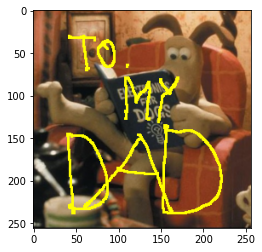

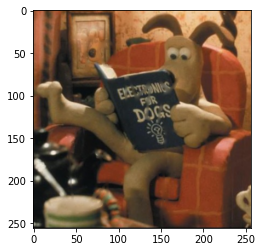

In [36]:
# Escreva o código desta etapa aqui.
imagem_corrigida = np.copy(imagem)

n = 0
for i in range(nx):
  for j in range(ny):
    if I[i, j] > -1:
      imagem_corrigida[i, j, 0] = xr[n]
      imagem_corrigida[i, j, 1] = xg[n]
      imagem_corrigida[i, j, 2] = xb[n]
      n += 1

plt.imshow(imagem)
plt.show()
plt.imshow(imagem_corrigida)
plt.show()


## Saiba mais

* Esta atividade foi baseada no artigo "Image inpainting", de Marcelo Bertalmio, Guillermo Sapiro, Vincent Caselles e Coloma Ballester, disponível em https://doi.org/10.1145/344779.344972.

2021 Vicente Helano  
UFCA | Centro de Ciências e Tecnologia